# Evolutionary Algorithm Script

This notebook is a little messy but contains the code we used to execute parameter search with evolutionary algorithms.

In [1]:
from typing import List, Tuple
import argparse
from collections import deque

import numpy as np
import torch
import yaml
from epsilon_transformers.process.MixedStateTree import (MixedStateTree,
                                                         MixedStateTreeNode)
from epsilon_transformers.process.Process import (
    Process, _compute_emission_probabilities, _compute_next_distribution)
from epsilon_transformers.process.processes import Mess3
from tqdm import tqdm

from src.utils import get_cached_belief_filename, MODEL_PATH_005_085, MODEL_PATH_015_06
from src.generate_paths_and_beliefs import generate_mess3_beliefs, save_beliefs
from typing import Tuple, Set, List
from pathlib import Path
from transformer_lens import HookedTransformer
from src.experiment import run_activation_to_beliefs_regression, r_squared, load_model

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.12/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


First, we create functions that can generate the ideal belief states for the sequences produced from a given HMM and then evaluate the reconstruction of these belief states from the residual stream of a given model. The reconstruction is scored using the $R^2$ of the regression. These two functions constitute the reward signal of our evolutionary search.

In [7]:
def get_beliefs(x: float, a: float):
    file_path = Path(get_cached_belief_filename(x, a))
    if file_path.exists():
        return torch.load(file_path)
    else:
        inputs, input_beliefs = generate_mess3_beliefs(x, a, sort_pairs=True)
        # save_beliefs(inputs, input_beliefs, x, a)
        return {
            "params": {"x": x, "a": a},
            "inputs": inputs,
            "input_beliefs": input_beliefs,
        }

def evaluate(model: HookedTransformer, inputs: torch.Tensor, input_beliefs: torch.Tensor):
    _, activations = model.run_with_cache(
            inputs, names_filter=lambda x: "resid_post" in x
        )
    acts = activations["blocks.3.hook_resid_post"].cpu().detach().numpy()
    regression, belief_predictions = run_activation_to_beliefs_regression(
        acts, input_beliefs
    )

    rsq = r_squared(input_beliefs, belief_predictions)

    return rsq

Initialize model and verify the above functions work (corroborated from data with scripts in `src`).

In [121]:
p = get_beliefs(0.01, 0.9)
device = torch.device("cuda:1")
model = load_model(MODEL_PATH_005_085 / "684806400.pt", MODEL_PATH_005_085 / "train_config.json", device)
evaluate(model, p["inputs"], p["input_beliefs"])

tensor(0.9542, dtype=torch.float64)

### Evolutionary Algorithm

We run the boilerplate evolutionary algorithm with the $R^2$ reward signal. Each new set of parameters is evaluated according to the reconstruction error of its corresponding linear probe.
- `mutation_rate` indicates the probability for each parameter that we add Gaussian random noise to it before evaluation. The noise has standard deviation equal to one-tenth the range for each parameter (`range=1.0` for `x` and `range=0.5` for alpha).
- `elitism` determines how many parameters are kept between generations.
- `crossover_rate` determines the rate at which the parameters of parents are swapped for their children.

The code below performs evolutionary search on Mess3(0.05, 0.85)

In [47]:
import random
import numpy as np

# Define parameters
population_size = 10
generations = 5
mutation_rate = 0.5
crossover_rate = 0.7
elitism = 2

# Define ranges for x and a
x_range = (0.001, 0.5)
a_range = (0, 1)

# Fitness function
def evaluate_fitness(chromosome):
    x, a = chromosome
    belief_dict = get_beliefs(x, a)
    fitness = evaluate(model, belief_dict["inputs"], belief_dict["input_beliefs"])

    score = -torch.log(1 - fitness)

    return score

# Initialize population
def initialize_population(size):
    population = []
    for _ in range(size):
        x = random.uniform(*x_range)
        a = random.uniform(*a_range)
        population.append([x, a])
    return population

# Selection (Tournament Selection)
def select_parents(population, fitness, k=3):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitness)), k)
        winner = max(tournament, key=lambda ind: ind[1])[0]
        selected.append(winner)
    return selected

# Crossover (Single-Point Crossover)
def crossover(parent1, parent2):
    if random.random() < crossover_rate:
        point = random.randint(1, 1)
        child1 = [parent1[0], parent2[1]]
        child2 = [parent2[0], parent1[1]]
        return child1, child2
    else:
        return parent1, parent2

# Mutation
def mutate(chromosome, mutation_rate, generation, max_generations):
    adjusted_mutation_rate = mutation_rate * (1 - (generation / max_generations))
    if random.random() < adjusted_mutation_rate:
        chromosome[0] = np.clip(chromosome[0] + np.random.normal(0, 0.05), *x_range)
    if random.random() < adjusted_mutation_rate:
        chromosome[1] = np.clip(chromosome[1] + np.random.normal(0, 0.1), *a_range)
    return chromosome

# Replacement (Elitism)
def replace_population(old_population, new_population, fitness, elitism_count):
    combined = list(zip(old_population, fitness)) + [(child, evaluate_fitness(child)) for child in new_population]
    combined.sort(key=lambda ind: ind[1], reverse=True)
    next_generation = [ind[0] for ind in combined[:elitism_count]]
    
    remaining = combined[elitism_count:]
    while len(next_generation) < population_size:
        candidate = remaining.pop(0)[0] if remaining else [random.uniform(*x_range), random.uniform(*a_range)]
        if not any(np.linalg.norm(np.array(candidate) - np.array(ind)) < 0.1 for ind in next_generation):
            next_generation.append(candidate)
    
    return next_generation

# Main evolutionary algorithm
def evolutionary_algorithm():
    all_generations = []
    population = initialize_population(population_size)
    for generation in range(generations):
        print(population)
        fitness = [evaluate_fitness(chromosome).item() for chromosome in population]
        
        parents = select_parents(population, fitness)
        offspring = []
        while len(offspring) < population_size:
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover(parent1, parent2)
            offspring.extend([mutate(child1, mutation_rate, generation, generations), mutate(child2, mutation_rate, generation, generations)])
        
        all_generations.append((population, fitness))

        population = replace_population(population, offspring, fitness, elitism)
    
    return all_generations

# Run the algorithm and print the best solution
all_generations = evolutionary_algorithm()
#    best_solution = max(population, key=evaluate_fitness)
# print("Best solution:", best_solution)
# print("Best fitness:", evaluate_fitness(best_solution))


[[0.156025603252551, 0.3454485226583415], [0.20225942053321166, 0.37674883878597354], [0.4780575432264609, 0.6356897795321035], [0.16525168919536862, 0.8382619123293342], [0.4385711151054011, 0.8682378729017474], [0.07172261515633209, 0.16198630825817473], [0.4414872737929617, 0.9784732272309548], [0.14622688602064188, 0.1427556990488965], [0.10879318870654392, 0.8318591122599809], [0.2864543573872564, 0.36946349053349303]]
[[0.10879318870654392, 0.7545296939283862], [0.10879318870654392, 0.7545296939283862], [0.10879318870654392, 0.9026535820937317], [0.19162293387897505, 0.9784732272309548], [0.4414872737929617, 0.9784732272309548], [0.2864543573872564, 0.36946349053349303], [0.14120628037044874, 0.5296119289580805], [0.14622688602064188, 0.1427556990488965], [0.4385711151054011, 0.8682378729017474], [0.4780575432264609, 0.6356897795321035]]
[[0.06778643245796745, 1.0], [0.06778643245796745, 1.0], [0.10879318870654392, 0.9026535820937317], [0.19162293387897505, 0.9784732272309548], [

In [131]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_n_coordinates(data, n, real_param, max_param=None):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Different colors for each tuple
    plt.figure(figsize=(10, 6))
    noise_level = 0.005  # Adjust noise level as needed

    all_coords = []
    
    for idx, (coords, z_values) in enumerate(data):
        # Convert lists to numpy arrays for easy manipulation
        coords = np.array(coords)
        z_values = np.array(z_values)
        
        # Get the indices of the top 5 z-values
        top_5_indices = np.argsort(z_values)[-n:]
        
        # Get the corresponding coordinates
        top_5_coords = coords[top_5_indices]
        
        # Collect all top 5 coordinates
        all_coords.append(top_5_coords)
    
    # Flatten the list of coordinates
    all_coords = np.vstack(all_coords)
    
    # Add noise to duplicates within and between tuples
    unique_coords, counts = np.unique(all_coords, axis=0, return_counts=True)
    for coord, count in zip(unique_coords, counts):
        if count > 1:
            duplicates = np.where((all_coords == coord).all(axis=1))[0]
            noise = np.random.normal(0, noise_level, (count, 2))
            all_coords[duplicates] += noise

    # Plot the points
    start = 0
    for idx, (coords, z_values) in enumerate(data):
        num_points = len(np.argsort(z_values)[-n:])
        top_5_coords = all_coords[start:start + num_points]
        start += num_points
        
        plt.scatter(top_5_coords[:, 0], top_5_coords[:, 1], color=colors[idx % len(colors)], label=f'Generation {idx+1}')
    
    # Plot real_param if provided
    if real_param is not None:
        plt.scatter(real_param[0], real_param[1], color='black', marker='x', s=100, label='Real Param')

    # Plot max_param if provided
    if max_param is not None:
        plt.scatter(max_param[0], max_param[1], color='black', marker='o', s=100, label='Param with max R^2')

    plt.xlim(0, 0.55)
    plt.ylim(0, 1.1)
    plt.xlabel('x')
    plt.ylabel('alpha')
    plt.title(f'Top {n} coordinates in each generation by R^2 for Mess3({real_param[0]},{real_param[1]})')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig(f"evo_alg_{str(real_param).replace('.','')}.jpg")


Evolutionary algorithm for Mess3(0.15, 0.6)

In [98]:
import random
import numpy as np

# Define parameters
population_size = 10
generations = 5
mutation_rate = 0.5
crossover_rate = 0.7
elitism = 2
model_015_06 = load_model(MODEL_PATH_015_06 / "998406400.pt", MODEL_PATH_015_06 / "train_config.json", device)

# Define ranges for x and a
x_range = (0.001, 0.5)
a_range = (0, 1)

# Fitness function
def evaluate_fitness(chromosome):
    x, a = chromosome
    belief_dict = get_beliefs(x, a)
    fitness = evaluate(model_015_06, belief_dict["inputs"], belief_dict["input_beliefs"])

    score = -torch.log(1 - fitness)

    return score

# Initialize population
def initialize_population(size):
    population = []
    for _ in range(size):
        x = random.uniform(*x_range)
        a = random.uniform(*a_range)
        population.append([x, a])
    return population

# Selection (Tournament Selection)
def select_parents(population, fitness, k=3):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitness)), k)
        winner = max(tournament, key=lambda ind: ind[1])[0]
        selected.append(winner)
    return selected

# Crossover (Single-Point Crossover)
def crossover(parent1, parent2):
    if random.random() < crossover_rate:
        point = random.randint(1, 1)
        child1 = [parent1[0], parent2[1]]
        child2 = [parent2[0], parent1[1]]
        return child1, child2
    else:
        return parent1, parent2

# Mutation
def mutate(chromosome, mutation_rate, generation, max_generations):
    adjusted_mutation_rate = mutation_rate * (1 - (generation / max_generations))
    if random.random() < adjusted_mutation_rate:
        chromosome[0] = np.clip(chromosome[0] + np.random.normal(0, 0.05), *x_range)
    if random.random() < adjusted_mutation_rate:
        chromosome[1] = np.clip(chromosome[1] + np.random.normal(0, 0.1), *a_range)
    return chromosome

# Replacement (Elitism)
def replace_population(old_population, new_population, fitness, elitism_count):
    combined = list(zip(old_population, fitness)) + [(child, evaluate_fitness(child)) for child in new_population]
    combined.sort(key=lambda ind: ind[1], reverse=True)
    next_generation = [ind[0] for ind in combined[:elitism_count]]
    
    remaining = combined[elitism_count:]
    while len(next_generation) < population_size:
        candidate = remaining.pop(0)[0] if remaining else [random.uniform(*x_range), random.uniform(*a_range)]
        if not any(np.linalg.norm(np.array(candidate) - np.array(ind)) < 0.1 for ind in next_generation):
            next_generation.append(candidate)
    
    return next_generation

# Main evolutionary algorithm
def evolutionary_algorithm():
    all_generations = []
    population = initialize_population(population_size)
    for generation in range(generations):
        print(population)
        fitness = [evaluate_fitness(chromosome).item() for chromosome in population]
        
        parents = select_parents(population, fitness)
        offspring = []
        while len(offspring) < population_size:
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover(parent1, parent2)
            offspring.extend([mutate(child1, mutation_rate, generation, generations), mutate(child2, mutation_rate, generation, generations)])
        
        all_generations.append((population, fitness))

        population = replace_population(population, offspring, fitness, elitism)
    
    return all_generations

# Run the algorithm and print the best solution
all_generations_015_06 = evolutionary_algorithm()
#    best_solution = max(population, key=evaluate_fitness)
# print("Best solution:", best_solution)
# print("Best fitness:", evaluate_fitness(best_solution))


[[0.2237053951880423, 0.3875567617762785], [0.40570498859119225, 0.8246237414125815], [0.0953124927265816, 0.549274669046123], [0.2521619182095867, 0.9840831451103498], [0.4719161175877988, 0.7484779911740637], [0.2465912624458304, 0.7699582133123081], [0.3877053056874437, 0.41069359497015534], [0.43712559366130166, 0.8419733623027538], [0.08812819730273326, 0.9471755536294861], [0.12068903187817678, 0.2523815859230655]]
[[0.16812079194791113, 0.3941566986351583], [0.1541138413548201, 0.3875567617762785], [0.08812819730273326, 0.9471755536294861], [0.12068903187817678, 0.5548716094982519], [0.2465912624458304, 0.7699582133123081], [0.19647390154596964, 0.9471755536294861], [0.12068903187817678, 0.2523815859230655], [0.40570498859119225, 0.8246237414125815], [0.3877053056874437, 0.41069359497015534], [0.2237053951880423, 0.03976337480257178]]
[[0.16812079194791113, 0.531017593169953], [0.19281621875178517, 0.5548716094982519], [0.16812079194791113, 0.3941566986351583], [0.12068903187817

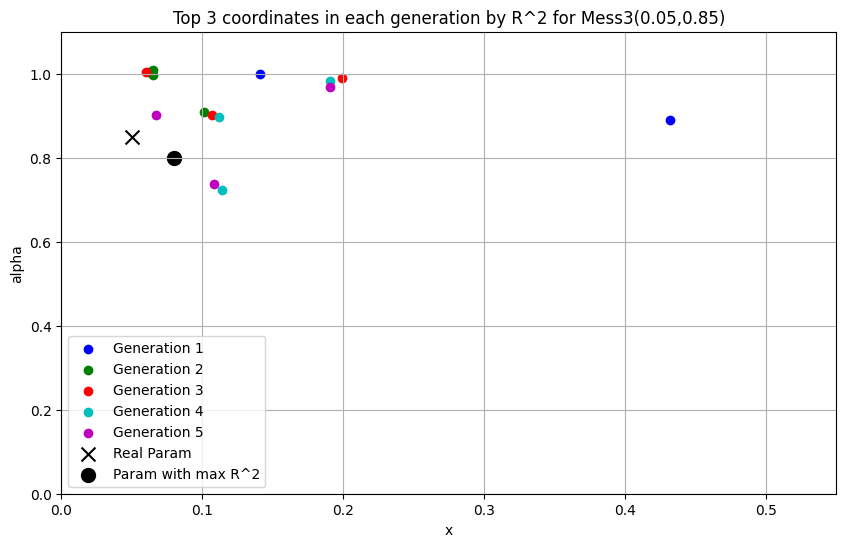

<Figure size 640x480 with 0 Axes>

In [132]:
plot_top_n_coordinates(all_generations, 3, (0.05, 0.85), (0.08, 0.8))

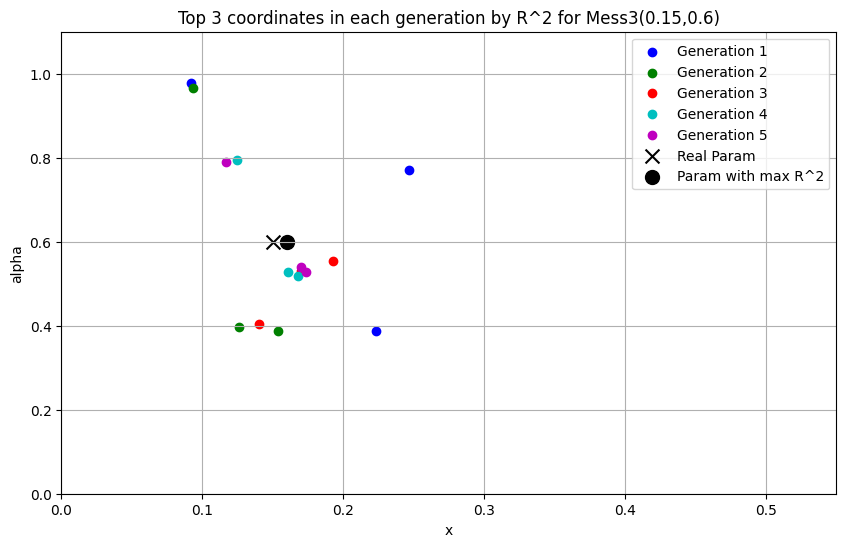

<Figure size 640x480 with 0 Axes>

In [133]:
plot_top_n_coordinates(all_generations_015_06, 3, (0.15, 0.6), (0.16, 0.6))

### Messy code to evaluate R-squared (ignore)

In [ ]:
import math
max_r2 = 0
max_point = []
max_gen = 0
for gen_idx, (points, fitnesses) in enumerate(all_generations_015_06):
    for i in range(len(points)):
        if 1 - math.exp(-fitnesses[i]) > max_r2:
            max_r2 = 1 - math.exp(-fitnesses[i])
            max_point = points[i]
            max_gen = gen_idx + 1
print(max_point, max_r2, max_gen)

In [ ]:
points = [max_point, [0.15, 0.6], [0.16, 0.6]]

for x, a in points:
    belief_dict = get_beliefs(x, a)
    print(x, a, evaluate(model_015_06, belief_dict["inputs"], belief_dict["input_beliefs"]))

In [ ]:
import math
max_r2 = 0
max_point = []
max_gen = 0
for gen_idx, (points, fitnesses) in enumerate(all_generations):
    for i in range(len(points)):
        if 1 - math.exp(-fitnesses[i]) > max_r2:
            max_r2 = 1 - math.exp(-fitnesses[i])
            max_point = points[i]
            max_gen = gen_idx + 1
print(max_point, max_r2, max_gen)

In [ ]:
points = [max_point, [0.05, 0.85], [0.08, 0.8]]

for x, a in points:
    belief_dict = get_beliefs(x, a)
    print(x, a, evaluate(model, belief_dict["inputs"], belief_dict["input_beliefs"]))